<strong><font size="8">A4</font></strong>

In [1]:
from pathlib import Path
import re
import warnings

import numpy
import scipy# import stats
import eelbrain
from matplotlib import pyplot
import mne
import seaborn


# Define some paths that will be used throughout
DATA_ROOT = Path("~").expanduser() / 'Data' / 'Alice'
STIMULUS_DIR = DATA_ROOT / 'stimuli'
EEG_DIR = DATA_ROOT / 'eeg'

# General parameters
LOW_FREQUENCY = 0.5
HIGH_FREQUENCY = 20
SAMPLINGRATE = 50

mne.set_log_level('WARNING')  # supresses most useless outputs

# Suppress warning on low pass filter
warnings.filterwarnings("ignore", category=RuntimeWarning, message="The measurement information indicates a low-pass frequency of 20.0 Hz.*")

In [2]:
#----------------------# SETUP #----------------------#
SUBJECTS = [path.name for path in EEG_DIR.iterdir() if path.name.startswith('S')]

# Define latency windows
RANGES = [(i/10, (i+1)/10) for i in range(6)]
# Add some latencies further out
RANGES.append((0.9, 1.0))
RANGES.append((1.9, 2.0))

#----------------------# GENERATE ENVELOPE #----------------------#
envelopes = {}
for stimulus_id in range(1, 13):
    wav = eelbrain.load.wav(STIMULUS_DIR / f'{stimulus_id}.wav')
    envelope = wav.envelope()
    envelope = eelbrain.filter_data(envelope, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
    envelope = eelbrain.resample(envelope, SAMPLINGRATE)
    envelopes[f'{stimulus_id}'] = envelope

In [3]:
#----------------------# TRF #----------------------#

# Container for collecting decoders
decoders = {}
# Loop through subjects
for subject in SUBJECTS[:]:
    # Load the subject's data
    raw = mne.io.read_raw(EEG_DIR / subject / f'{subject}_alice-raw.fif', preload=True)
    raw.filter(LOW_FREQUENCY, HIGH_FREQUENCY, n_jobs=1)
    events = eelbrain.load.mne.events(raw)
    # Add the envelopes corresponding to the trials
    events['envelope'] = [envelopes[stimulus_id] for stimulus_id in events['event']]
    # Extract the stimulus duration (in seconds) from the envelopes
    events['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']])
    # extract EEG data corresponding exactly to the timing of the envelopes
    events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=10, connectivity='auto')

    # Train decoders for this subject 
    decoders[subject] = {}
    for tstart, tstop in RANGES[:]:
        model = eelbrain.boosting('envelope', 'eeg', -tstop, -tstart, partitions=4, data=events, delta=0.05, test=True)
        decoders[subject][tstart] = model

Text(0.5, 1.0, 'Envelope reconstruction as a function of sound/EEG lag')

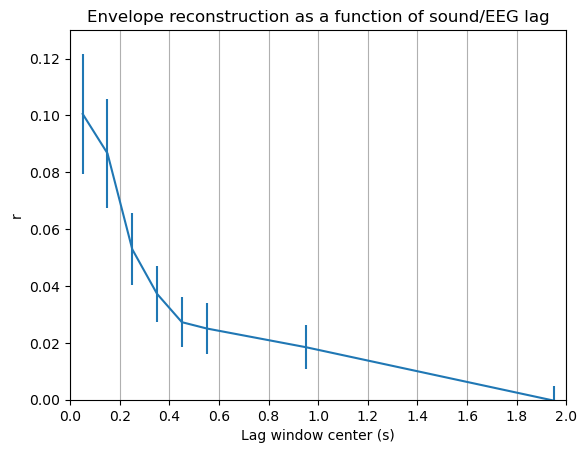

In [4]:
#----------------------# T-TEST #----------------------#

# Extract decoding performance (use Pearson correlation between the reconstructed and actual envelope)
rows = []
for subject in SUBJECTS:
    row = []
    for tstart, tstop in RANGES:
        row.append(decoders[subject][tstart].r)
    rows.append(row)

# Subject x latency matrix
data = numpy.array(rows)

# Calculate t-statistics for each latency window 
ttest = scipy.stats.ttest_1samp(data, 0)
ttest

#----------------------# PLOTTING #----------------------#

# Plot decoding performance as function of lag
x = [(tstart + tstop) / 2 for tstart, tstop in RANGES]
y = data.mean(0)
ci = ttest.confidence_interval()
yerr = ci.high - y
pyplot.errorbar(x, y, yerr=yerr)
pyplot.xticks(numpy.arange(0, 2.1, 0.200))
pyplot.grid(axis='x')
pyplot.ylabel('r')
pyplot.xlabel('Lag window center (s)')
pyplot.ylim(0, 0.13)
pyplot.xlim(RANGES[0][0], RANGES[-1][1])
pyplot.title("Envelope reconstruction as a function of sound/EEG lag")